In [13]:
from robovast.common.analysis import read_output_files, read_output_csv, get_behavior_info
import pandas as pd
from robovast_nav.gui import MapVisualizer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
DATA_DIR = '/home/fred/git/robovast/results/run-2026-02-11-203525/test-2'

df = read_output_files(DATA_DIR, lambda test_dir: read_output_csv(test_dir, "poses.csv"))

# Error checking: Ensure we have data
if df.empty:
    raise ValueError("No pose data found. Please check DATA_DIR path and ensure pose files exist.")

# Generate colors for each test
tests = df['test'].unique()
if len(tests) == 0:
    raise ValueError("No test data found in the dataframe.")

colors = cm.rainbow(np.linspace(0, 1, len(tests)))

df.loc[df['frame'] == 'base_link', 'position.x'] += 8

df_behaviors = read_output_files(DATA_DIR, lambda test_dir: read_output_csv(test_dir, "behaviors.csv"))
if df_behaviors.empty:
    raise ValueError("No behavior data found. Please check DATA_DIR path and ensure behavior files exist.")

df_behavior_info = get_behavior_info('differential_drive_robot.nav_to_pose', df_behaviors)
if df_behavior_info.empty:
    raise ValueError("No behavior info extracted. Check if 'differential_drive_robot.nav_to_pose' behavior exists in the data.")


## Overview

Skipping Run 0: insufficient data points (0 points)
Skipping Run 1: insufficient data points (0 points)


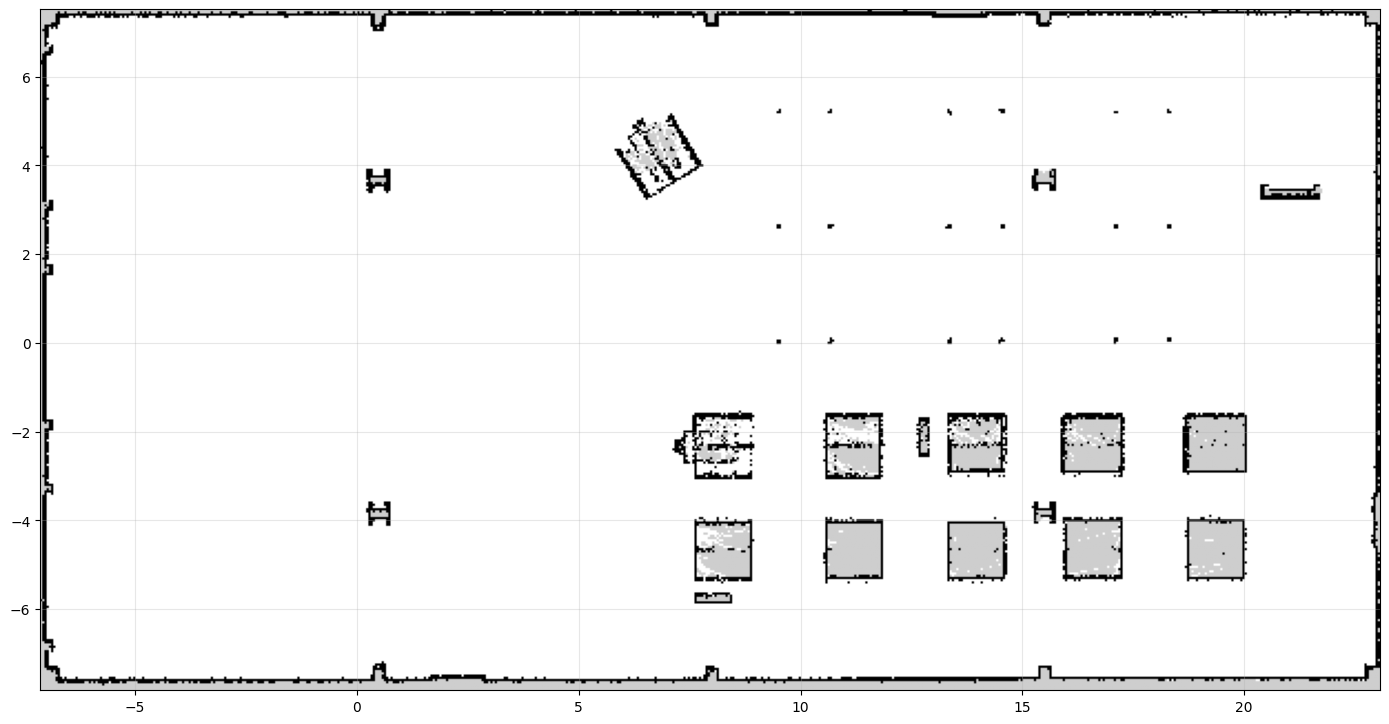

In [ ]:
# Multi-Run Comparison: All Robot Paths Ground Truth

# Create single visualization with all robot paths ground truth
viz = MapVisualizer()
viz.load_map("/opt/ros/jazzy/share/nav2_bringup/maps/depot.yaml")
viz.create_figure(figsize=(14, 12))

# Draw all robot paths with validation
paths_drawn = 0
for test, color in zip(tests, colors):
    df_test = df[df['test'] == test]
    df_gt_mask = df_test['frame'] == 'base_link'
    path_robot = list(zip(df_test.loc[df_gt_mask, 'position.x'], df_test.loc[df_gt_mask, 'position.y']))
    
    # Only draw paths with at least 2 points
    if len(path_robot) >= 2:
        viz.draw_path(path_robot, color=color, linewidth=1.5, label=f'Run {test}', show_endpoints=False)
        paths_drawn += 1
    else:
        print(f"Skipping Run {test}: insufficient data points ({len(path_robot)} points)")

if paths_drawn == 0:
    print("Warning: No valid paths to display. All tests have insufficient data.")
else:
    viz.ax.set_title(f'Multi-Run Comparison: {paths_drawn}/{len(tests)} Robot Paths', 
                     fontsize=14, fontweight='bold')
    viz.ax.legend(loc='upper left', fontsize=9, ncol=2)

plt.tight_layout()
plt.show()

## Navigation Duration Analysis

In [9]:
# # Analyze navigation duration across all runs
# print("Navigation Duration Statistics:")
# print("="*80)

# # Display the behavior info dataframe
# print(f"\nTotal runs analyzed: {len(df_behavior_info)}")
# print(f"\nDuration statistics:")
# print(f"  Mean: {df_behavior_info['duration'].mean():.2f} seconds")
# print(f"  Std Dev: {df_behavior_info['duration'].std():.2f} seconds")
# print(f"  Median: {df_behavior_info['duration'].median():.2f} seconds")
# print(f"  Min: {df_behavior_info['duration'].min():.2f} seconds")
# print(f"  Max: {df_behavior_info['duration'].max():.2f} seconds")
# print(f"  Range: {df_behavior_info['duration'].max() - df_behavior_info['duration'].min():.2f} seconds")
# print(f"  Coefficient of Variation: {(df_behavior_info['duration'].std()/df_behavior_info['duration'].mean())*100:.2f}%")

# print("\n" + "="*80)
# print("\nDetailed Duration by Run:")
# df_behavior_info

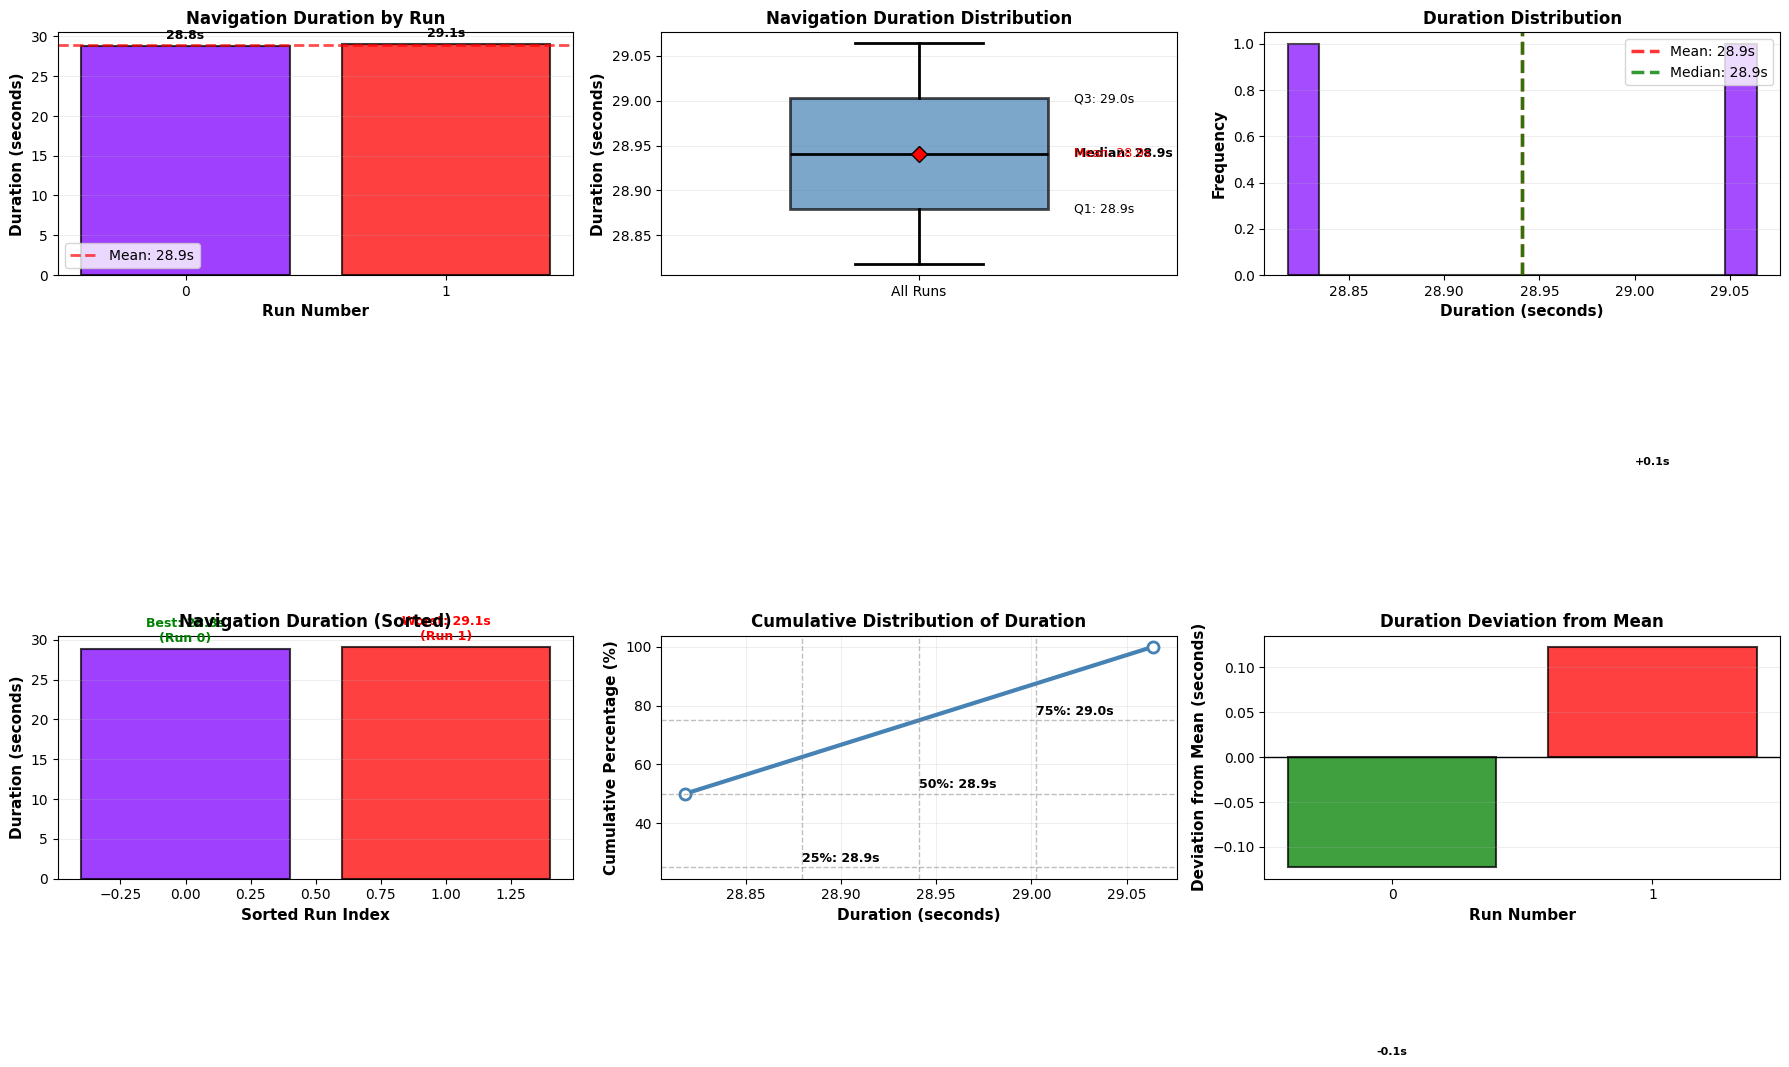

In [10]:
# Navigation Duration Comparison - Crisp Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Prepare data
durations = df_behavior_info['duration'].values
tests_behavior = df_behavior_info['test'].values
x_pos = np.arange(len(durations))

# 1. Bar Chart - Duration by Run
ax = axes[0, 0]
bars = ax.bar(x_pos, durations, alpha=0.75, color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Run Number', fontsize=11, fontweight='bold')
ax.set_ylabel('Duration (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Navigation Duration by Run', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{t}' for t in tests_behavior])
ax.grid(True, alpha=0.3, axis='y', linewidth=0.5)

# Add value labels
for i, duration in enumerate(durations):
    ax.text(i, duration + 0.5, f'{duration:.1f}s', ha='center', va='bottom', 
            fontsize=9, fontweight='bold')

# Add mean line
mean_duration = durations.mean()
ax.axhline(mean_duration, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_duration:.1f}s', alpha=0.7)
ax.legend(fontsize=10)

# 2. Box Plot - Duration Distribution
ax = axes[0, 1]
bp = ax.boxplot([durations], widths=0.5, patch_artist=True, 
                tick_labels=['All Runs'], showmeans=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][0].set_edgecolor('black')
bp['boxes'][0].set_linewidth(2)

for element in ['whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(bp[element], color='black', linewidth=2)
plt.setp(bp['means'], marker='D', markerfacecolor='red', markeredgecolor='black', markersize=8)

ax.set_ylabel('Duration (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Navigation Duration Distribution', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y', linewidth=0.5)

# Add statistics annotations
q1, median, q3 = np.percentile(durations, [25, 50, 75])
ax.text(1.3, q1, f'Q1: {q1:.1f}s', fontsize=9, va='center')
ax.text(1.3, median, f'Median: {median:.1f}s', fontsize=9, va='center', fontweight='bold')
ax.text(1.3, q3, f'Q3: {q3:.1f}s', fontsize=9, va='center')
ax.text(1.3, mean_duration, f'Mean: {mean_duration:.1f}s', fontsize=9, va='center', color='red')

# 3. Histogram - Duration Distribution
ax = axes[0, 2]
n, bins, patches = ax.hist(durations, bins=15, color='steelblue', alpha=0.7, 
                           edgecolor='black', linewidth=1.5)

# Color bars based on value
for i, patch in enumerate(patches):
    patch.set_facecolor(colors[i % len(colors)])

ax.axvline(mean_duration, color='red', linestyle='--', linewidth=2.5, 
           label=f'Mean: {mean_duration:.1f}s', alpha=0.8)
ax.axvline(median, color='green', linestyle='--', linewidth=2.5, 
           label=f'Median: {median:.1f}s', alpha=0.8)
ax.set_xlabel('Duration (seconds)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Duration Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y', linewidth=0.5)

# 4. Sorted Duration Plot
ax = axes[1, 0]
sorted_indices = np.argsort(durations)
sorted_durations = durations[sorted_indices]
sorted_tests = tests_behavior[sorted_indices]

bars = ax.bar(range(len(sorted_durations)), sorted_durations, alpha=0.75, 
              color=[colors[i] for i in sorted_indices], edgecolor='black', linewidth=1.5)
ax.set_xlabel('Sorted Run Index', fontsize=11, fontweight='bold')
ax.set_ylabel('Duration (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Navigation Duration (Sorted)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y', linewidth=0.5)

# Add labels for best and worst
ax.text(0, sorted_durations[0] + 0.5, f'Best: {sorted_durations[0]:.1f}s\n(Run {sorted_tests[0]})', 
        ha='center', va='bottom', fontsize=9, fontweight='bold', color='green')
ax.text(len(sorted_durations)-1, sorted_durations[-1] + 0.5, 
        f'Worst: {sorted_durations[-1]:.1f}s\n(Run {sorted_tests[-1]})', 
        ha='center', va='bottom', fontsize=9, fontweight='bold', color='red')

# 5. Cumulative Distribution
ax = axes[1, 1]
sorted_durations_cdf = np.sort(durations)
cumulative = np.arange(1, len(sorted_durations_cdf) + 1) * (100.0 / len(sorted_durations_cdf))

ax.plot(sorted_durations_cdf, cumulative, color='steelblue', linewidth=3, marker='o', 
        markersize=8, markerfacecolor='white', markeredgecolor='steelblue', markeredgewidth=2)
ax.set_xlabel('Duration (seconds)', fontsize=11, fontweight='bold')
ax.set_ylabel('Cumulative Percentage (%)', fontsize=11, fontweight='bold')
ax.set_title('Cumulative Distribution of Duration', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, linewidth=0.5)

# Add reference lines
for percentile in [25, 50, 75]:
    value = np.percentile(durations, percentile)
    ax.axhline(percentile, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    ax.axvline(value, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    ax.text(value, percentile + 2, f'{percentile}%: {value:.1f}s', fontsize=9, fontweight='bold')

# 6. Deviation from Mean
ax = axes[1, 2]
deviations = durations - mean_duration
colors_dev = ['green' if d <= 0 else 'red' for d in deviations]

bars = ax.bar(x_pos, deviations, alpha=0.75, color=colors_dev, edgecolor='black', linewidth=1.5)
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Run Number', fontsize=11, fontweight='bold')
ax.set_ylabel('Deviation from Mean (seconds)', fontsize=11, fontweight='bold')
ax.set_title('Duration Deviation from Mean', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{t}' for t in tests_behavior])
ax.grid(True, alpha=0.3, axis='y', linewidth=0.5)

# Add value labels
for i, dev in enumerate(deviations):
    va = 'bottom' if dev > 0 else 'top'
    offset = 0.2 if dev > 0 else -0.2
    ax.text(i, dev + offset, f'{dev:+.1f}s', ha='center', va=va, 
            fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()